### Dependencies

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.impute import KNNImputer
from sklearn.metrics import r2_score

import matplotlib.pyplot as plt

### Read into df

In [2]:
try:
    df = pd.read_csv("cancer_reg-1.csv", encoding='utf-8')
except UnicodeDecodeError:
    try:
        df = pd.read_csv("cancer_reg-1.csv", encoding='latin-1')
    except UnicodeDecodeError:
        df = pd.read_csv("cancer_reg-1.csv", encoding='cp1252')

print("Dataset loaded successfully!")
print(f"Shape: {df.shape}")
print(f"Number of features: {len(list(df.columns))}")
print(f"Columns: {list(df.columns)}")
print("\nFirst 5 rows:")
display(df.head())

Dataset loaded successfully!
Shape: (3047, 34)
Number of features: 34
Columns: ['avgAnnCount', 'avgDeathsPerYear', 'TARGET_deathRate', 'incidenceRate', 'medIncome', 'popEst2015', 'povertyPercent', 'studyPerCap', 'binnedInc', 'MedianAge', 'MedianAgeMale', 'MedianAgeFemale', 'Geography', 'AvgHouseholdSize', 'PercentMarried', 'PctNoHS18_24', 'PctHS18_24', 'PctSomeCol18_24', 'PctBachDeg18_24', 'PctHS25_Over', 'PctBachDeg25_Over', 'PctEmployed16_Over', 'PctUnemployed16_Over', 'PctPrivateCoverage', 'PctPrivateCoverageAlone', 'PctEmpPrivCoverage', 'PctPublicCoverage', 'PctPublicCoverageAlone', 'PctWhite', 'PctBlack', 'PctAsian', 'PctOtherRace', 'PctMarriedHouseholds', 'BirthRate']

First 5 rows:


,avgAnnCount,avgDeathsPerYear,TARGET_deathRate,incidenceRate,medIncome,popEst2015,povertyPercent,studyPerCap,binnedInc,MedianAge,...,PctPrivateCoverageAlone,PctEmpPrivCoverage,PctPublicCoverage,PctPublicCoverageAlone,PctWhite,PctBlack,PctAsian,PctOtherRace,PctMarriedHouseholds,BirthRate
0,1397.0,469,164.9,489.8,61898,260131,11.2,499.748204,"(61494.5, 125635]",39.3,...,NaN,41.6,32.9,14.0,81.780529,2.594728,4.821857,1.843479,52.856076,6.118831
1,173.0,70,161.3,411.6,48127,43269,18.6,23.111234,"(48021.6, 51046.4]",33.0,...,53.8,43.6,31.1,15.3,89.228509,0.969102,2.246233,3.741352,45.372500,4.333096
2,102.0,50,174.7,349.7,49348,21026,14.6,47.560164,"(48021.6, 51046.4]",45.0,...,43.5,34.9,42.1,21.1,90.922190,0.739673,0.465898,2.747358,54.444868,3.729488
3,427.0,202,194.8,430.4,44243,75882,17.1,342.637253,"(42724.4, 45201]",42.8,...,40.3,35.0,45.3,25.0,91.744686,0.782626,1.161359,1.362643,51.021514,4.603841
4,57.0,26,144.4,350.1,49955,10321,12.5,0.000000,"(48021.6, 51046.4]",48.3,...,43.9,35.1,44.0,22.7,94.104024,0.270192,0.665830,0.492135,54.027460,6.796657


In [3]:
# Missing values
print(df.isnull().sum()[df.isnull().sum() > 0]) if df.isnull().sum().sum() > 0 else print("No missing values found!")

# Min and max
min_list = dict()
max_list = dict()
numeric_columns = df.select_dtypes(include=[np.number]).columns
for column in numeric_columns:
    min_list[column] = df[column].min() 
    max_list[column] = df[column].max() 
print("Min values:", min_list)
print("Max values:", max_list)

PctSomeCol18_24            2285
PctEmployed16_Over          152
PctPrivateCoverageAlone     609
dtype: int64
Min values: {'avgAnnCount': 6.0, 'avgDeathsPerYear': 3, 'TARGET_deathRate': 59.7, 'incidenceRate': 201.3, 'medIncome': 22640, 'popEst2015': 827, 'povertyPercent': 3.2, 'studyPerCap': 0.0, 'MedianAge': 22.3, 'MedianAgeMale': 22.4, 'MedianAgeFemale': 22.3, 'AvgHouseholdSize': 0.0221, 'PercentMarried': 23.1, 'PctNoHS18_24': 0.0, 'PctHS18_24': 0.0, 'PctSomeCol18_24': 7.1, 'PctBachDeg18_24': 0.0, 'PctHS25_Over': 7.5, 'PctBachDeg25_Over': 2.5, 'PctEmployed16_Over': 17.6, 'PctUnemployed16_Over': 0.4, 'PctPrivateCoverage': 22.3, 'PctPrivateCoverageAlone': 15.7, 'PctEmpPrivCoverage': 13.5, 'PctPublicCoverage': 11.2, 'PctPublicCoverageAlone': 2.6, 'PctWhite': 10.1991551, 'PctBlack': 0.0, 'PctAsian': 0.0, 'PctOtherRace': 0.0, 'PctMarriedHouseholds': 22.99248989, 'BirthRate': 0.0}
Max values: {'avgAnnCount': 38150.0, 'avgDeathsPerYear': 14010, 'TARGET_deathRate': 362.8, 'incidenceRate': 120

# Step 1


## Data processing

In [4]:
# Drop literal column and missing to much value column
dropcol = ['binnedInc','PctSomeCol18_24','Geography','PctPrivateCoverageAlone']
df = df.drop(dropcol,axis=1)

In [5]:
# Use KNNImputer to impute missing value without causing significant change in meaning of dataset
imputer = KNNImputer(n_neighbors=df.shape[1])

imputed_data = imputer.fit_transform(df)

df = pd.DataFrame(imputed_data, columns=df.columns)

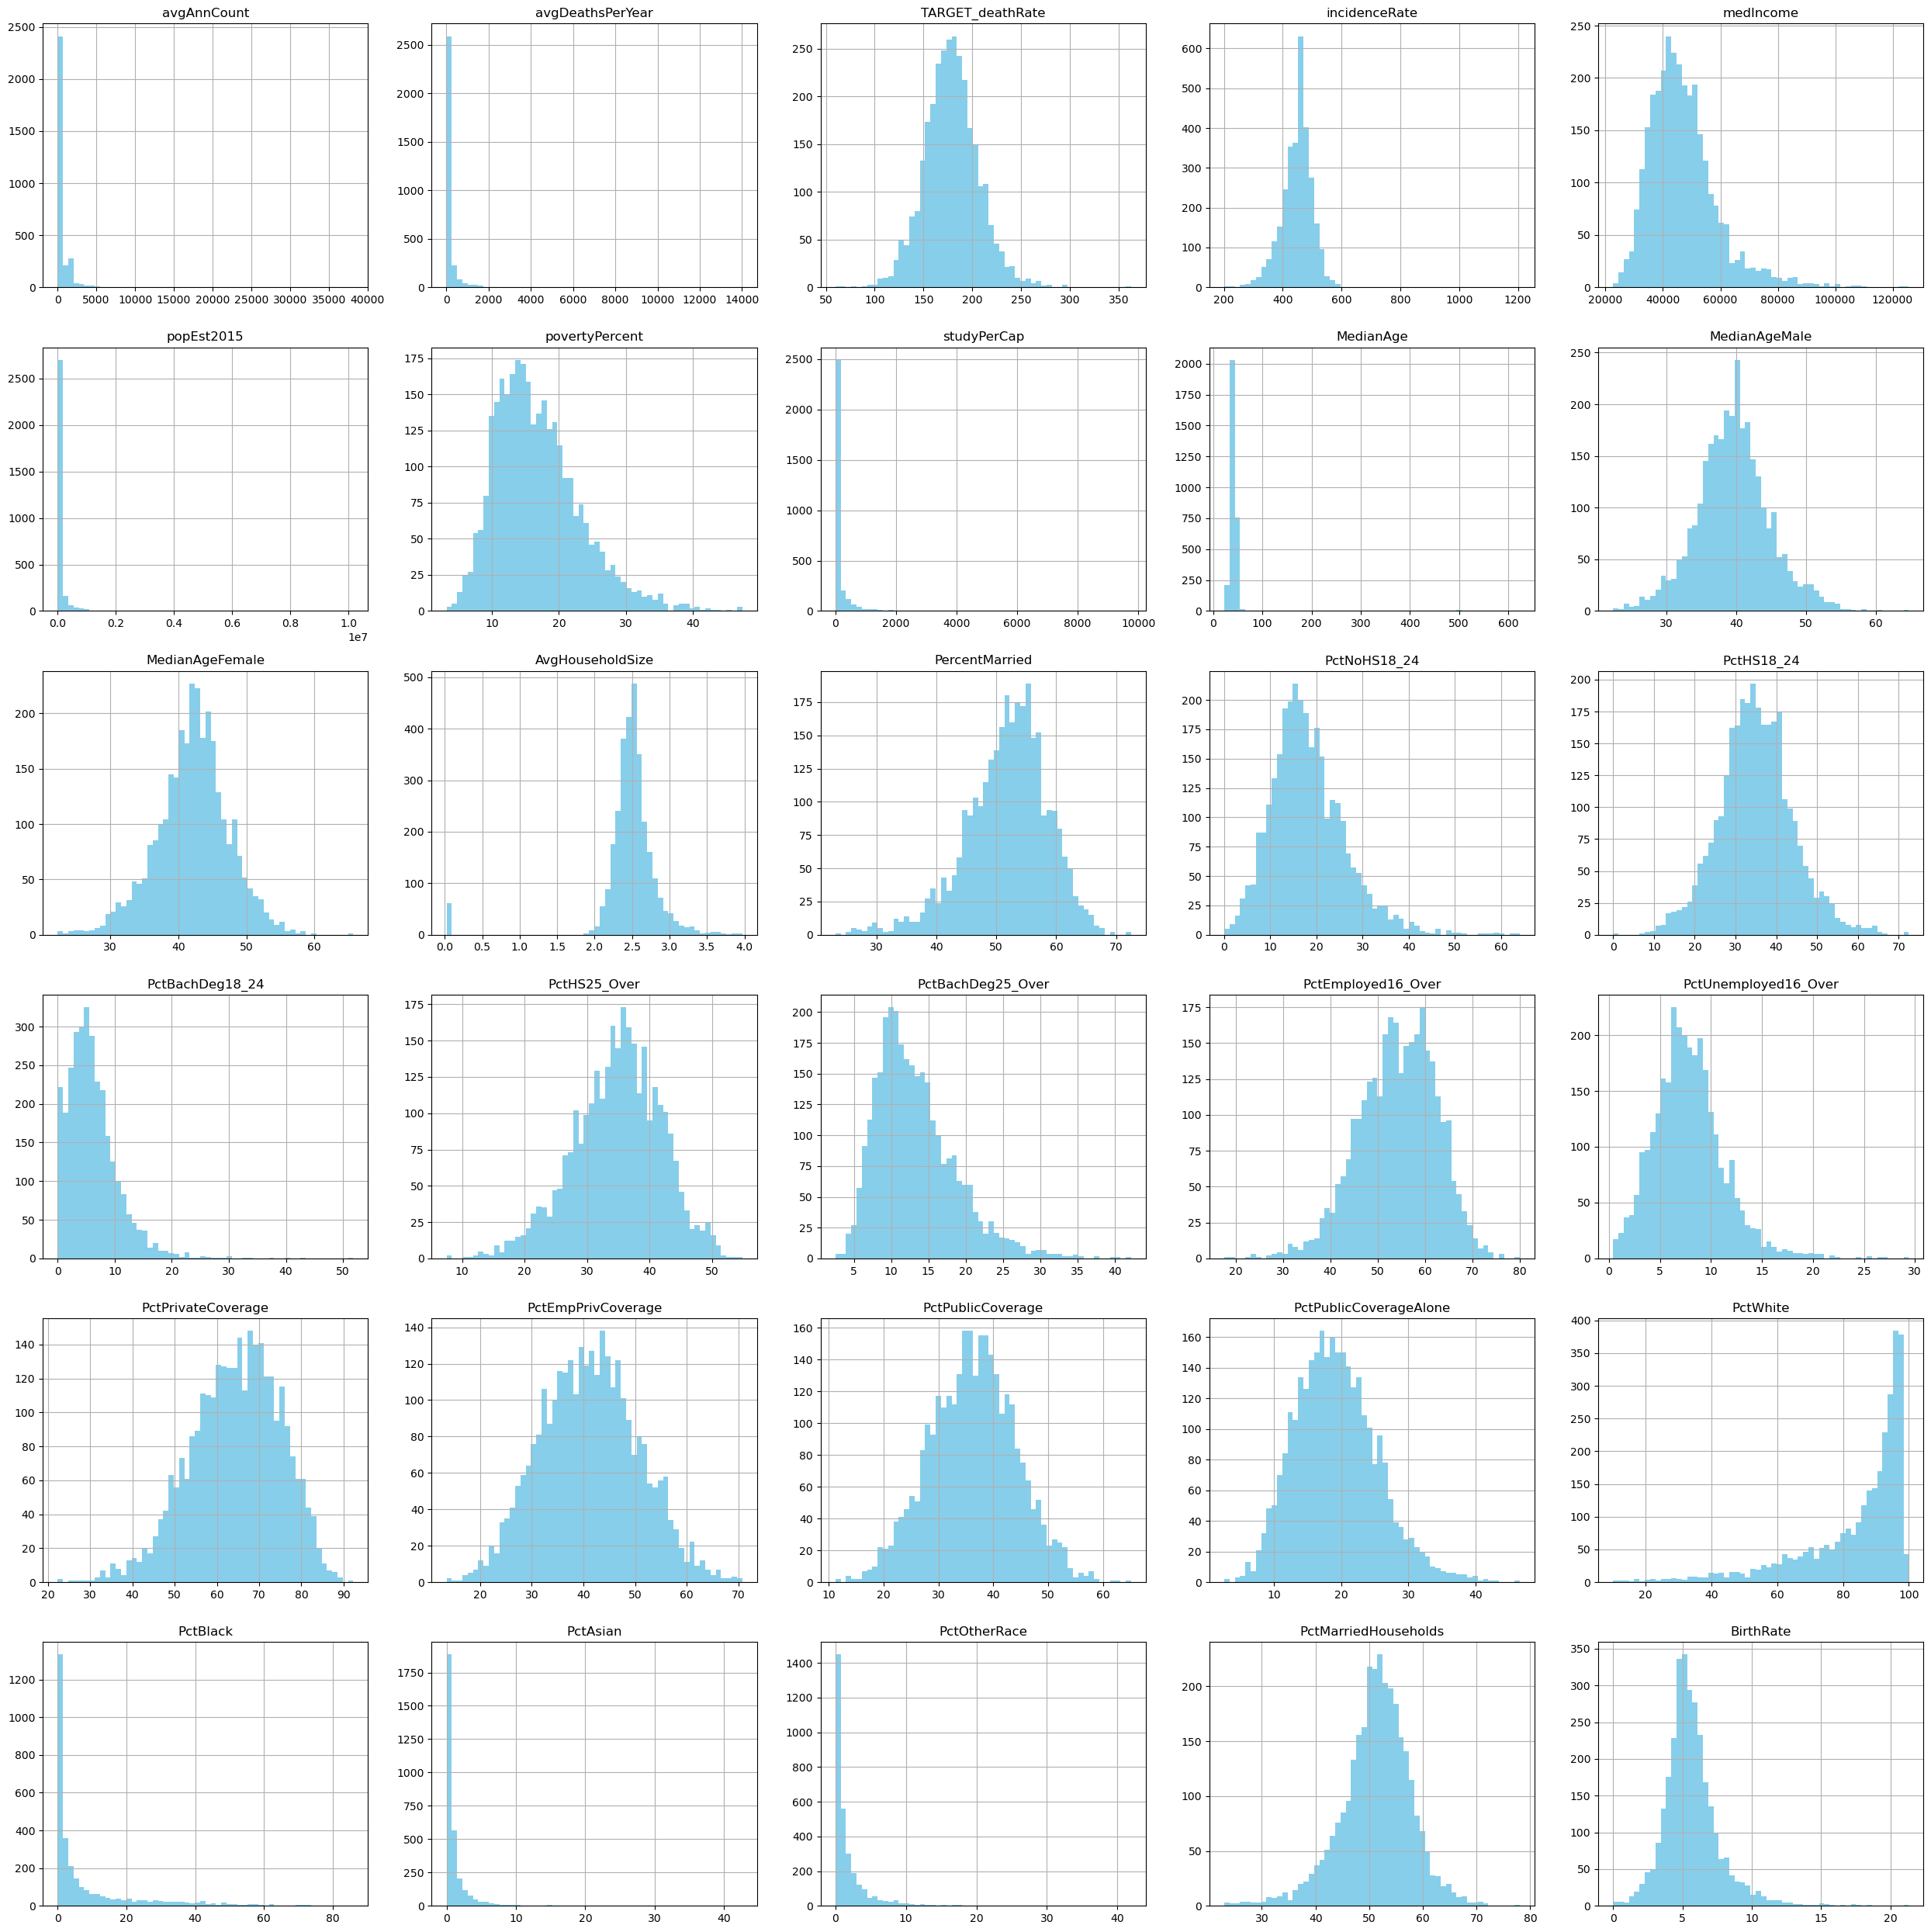

In [6]:
# Plot each feature
%matplotlib inline
import matplotlib.pyplot as plt
n_bins = int(np.ceil(np.sqrt(df.shape[0])))

training_data_with_targets = df
training_data_with_targets.hist(bins=n_bins, figsize=(25,25), color='skyblue')
plt.tight_layout()
plt.show()

In [7]:
# Function to handle skewed data 
def handle_skewed_columns(df, skew_threshold=0.75, method="yeo-johnson"):
    
    df_transformed = df.copy()
    numeric_cols = df_transformed.select_dtypes(include=[np.number]).columns

    # find skewed columns
    skewed = df_transformed[numeric_cols].skew().abs()
    skewed_cols = skewed[skewed > skew_threshold].index.tolist()

    print(f"Skewed columns: {skewed_cols}")

    for col in skewed_cols:
        if method == "log":
            df_transformed[col] = np.log1p(df_transformed[col].clip(lower=0))  
        elif method == "sqrt":
            df_transformed[col] = np.sqrt(df_transformed[col].clip(lower=0))
        elif method in ["box-cox", "yeo-johnson"]:
            pt = PowerTransformer(method=method, standardize=False)
            df_transformed[col] = pt.fit_transform(df_transformed[[col]])

    return df_transformed

In [8]:
df_fixed= handle_skewed_columns(df)

Skewed columns: ['avgAnnCount', 'avgDeathsPerYear', 'incidenceRate', 'medIncome', 'popEst2015', 'povertyPercent', 'studyPerCap', 'MedianAge', 'AvgHouseholdSize', 'PctNoHS18_24', 'PctBachDeg18_24', 'PctBachDeg25_Over', 'PctUnemployed16_Over', 'PctWhite', 'PctBlack', 'PctAsian', 'PctOtherRace', 'BirthRate']


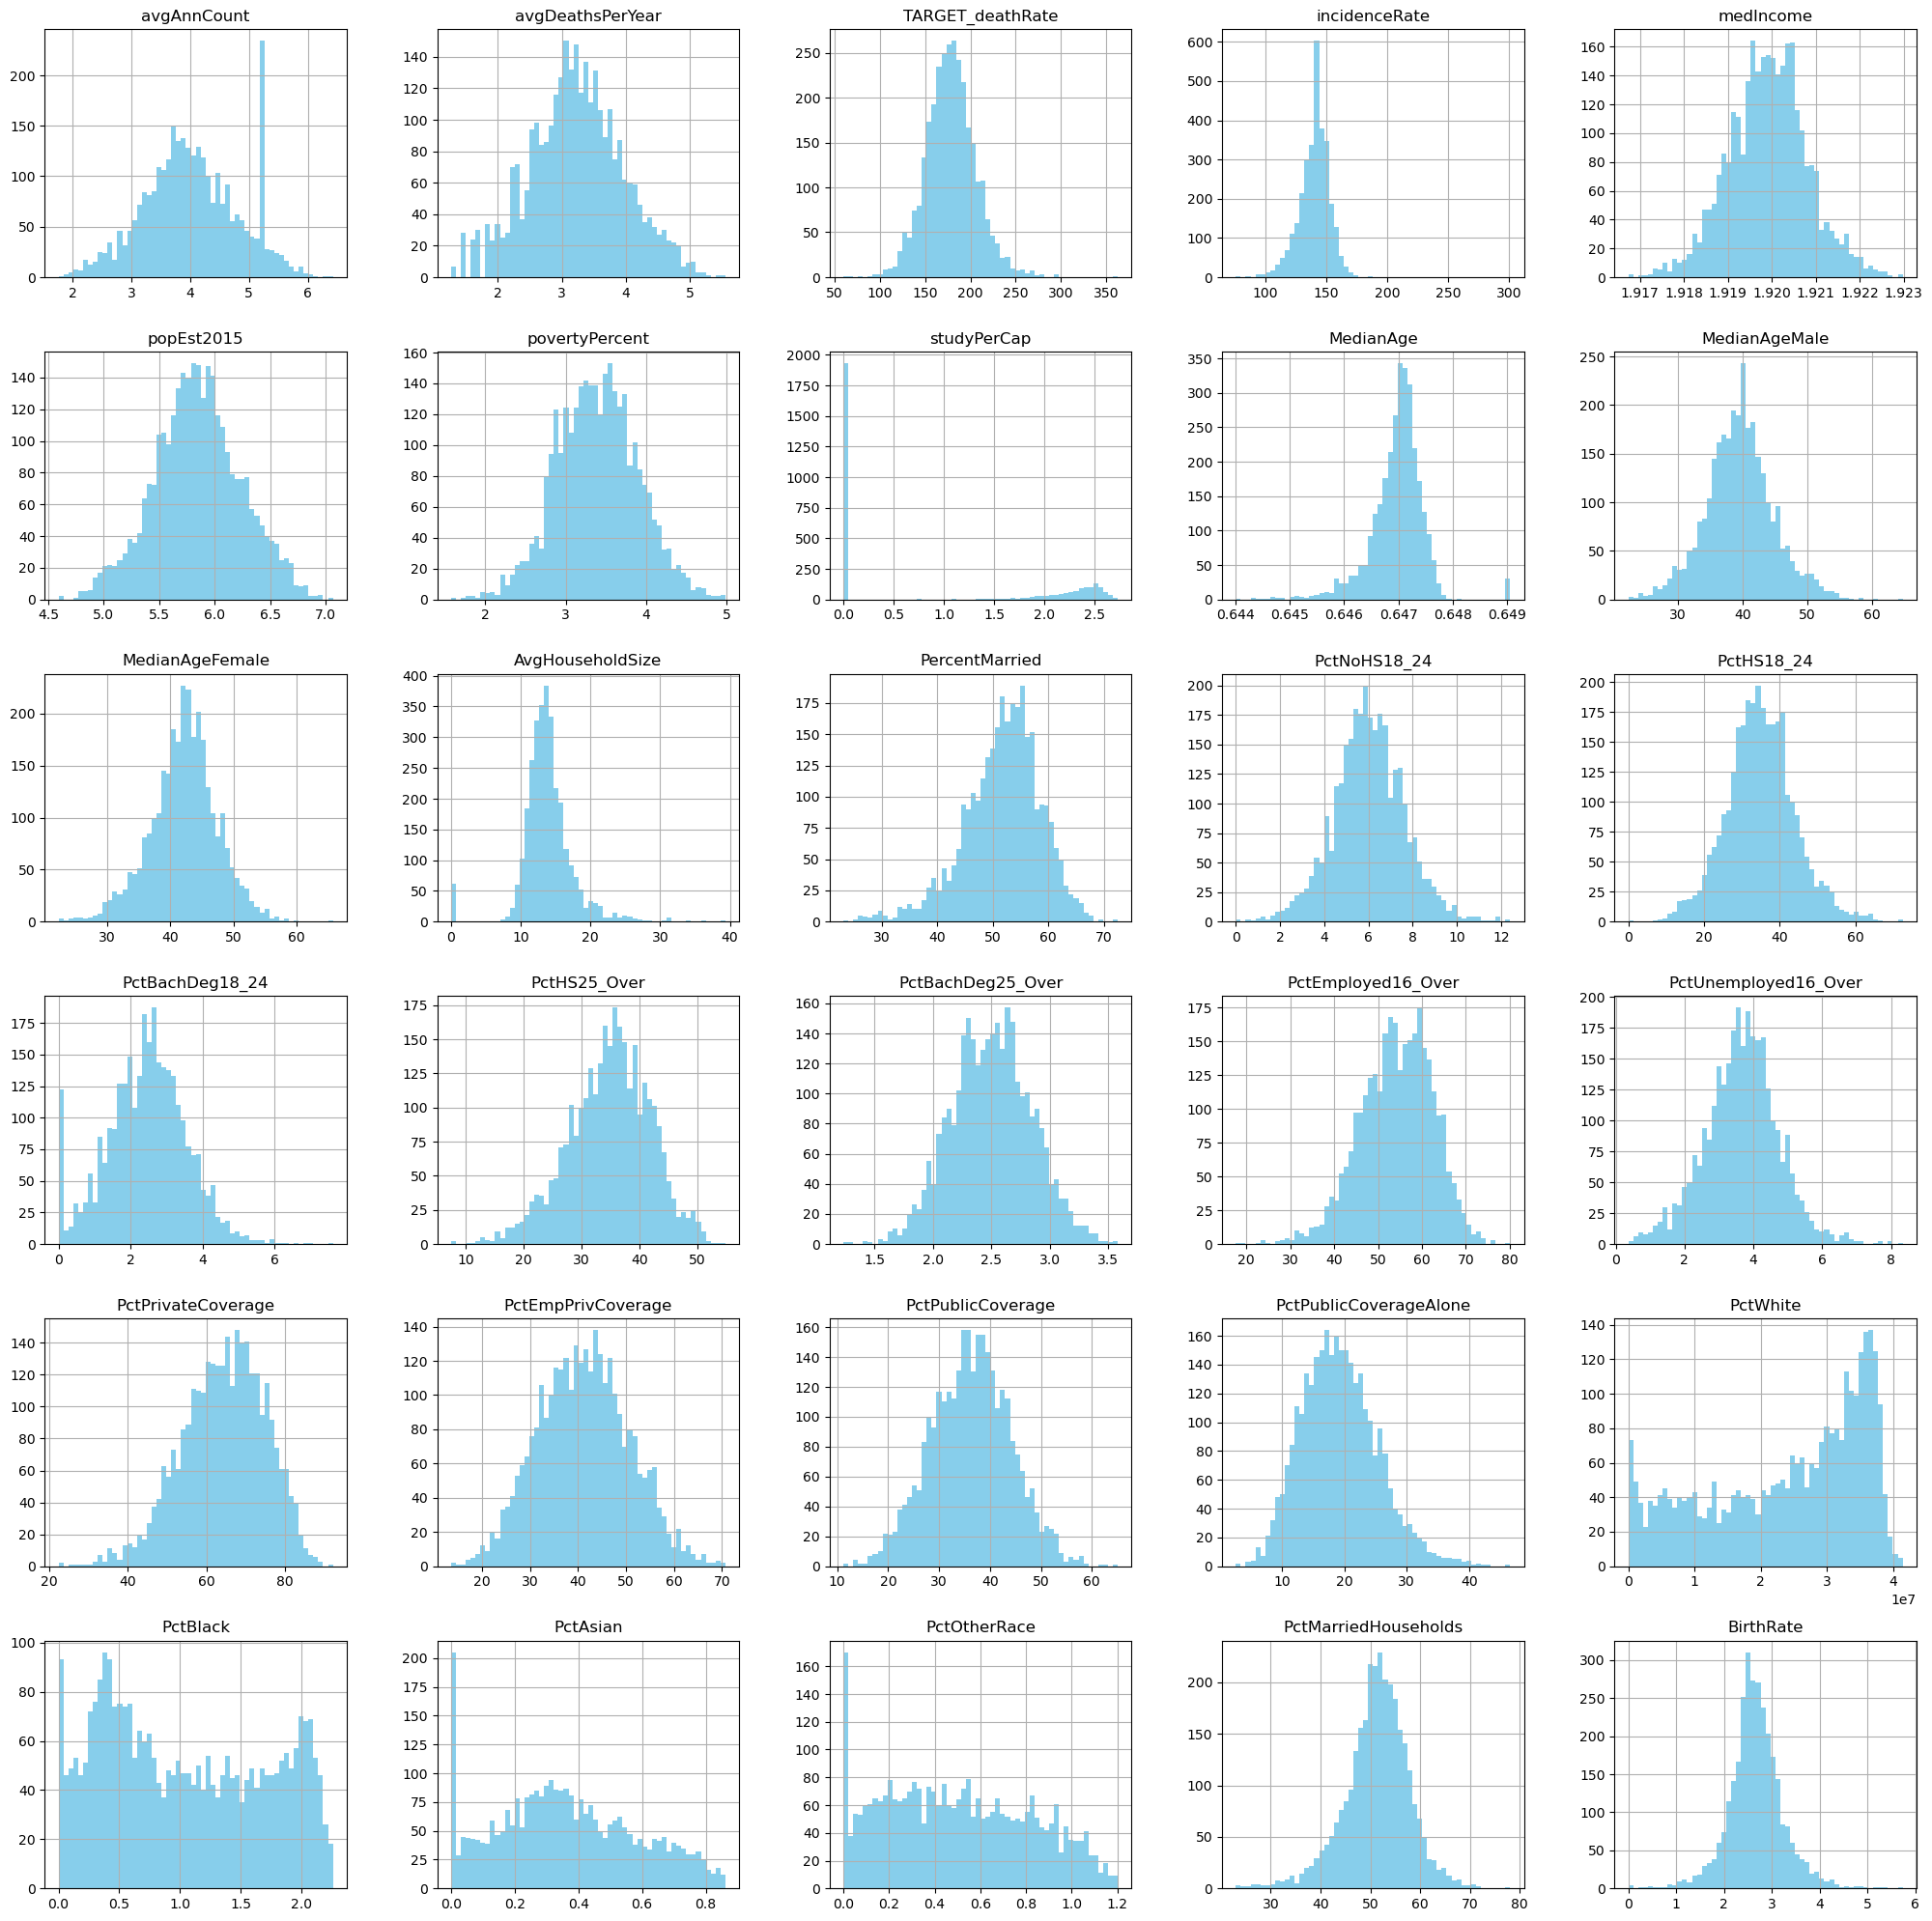

In [9]:
# Plot each feature after handling skewed data
%matplotlib inline
import matplotlib.pyplot as plt

n_bins = int(np.ceil(np.sqrt(df_fixed.shape[0])))

training_data_with_targets = df_fixed
training_data_with_targets.hist(bins=n_bins, figsize=(25,25), color='skyblue')
plt.show()

In [10]:
# Load data from dataframe and split and scale train and test
def load_data():
    y = df_fixed['TARGET_deathRate']               
    X = df_fixed.drop('TARGET_deathRate', axis=1)  

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, 
        test_size=0.15,      
        random_state=42,    
        stratify=None       
    )
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    return X_train_scaled, X_test_scaled, y_train, y_test

# Step 2

In [ ]:
num_feature = len(df_fixed.columns) - 1
# Define models
models = { 
    'linear-reg': tf.keras.Sequential([
        tf.keras.Input(shape=(num_feature,)),
        tf.keras.layers.Dense(1)
    ]),
    'dnn-16': tf.keras.Sequential([
        tf.keras.Input(shape=(num_feature,)),
        tf.keras.layers.Dense(16, activation='relu'),
        tf.keras.layers.Dense(1)
    ]),
    'dnn-30-8': tf.keras.Sequential([
        tf.keras.Input(shape=(num_feature,)),
        tf.keras.layers.Dense(30, activation='relu'),
        tf.keras.layers.Dense(8, activation='relu'),
        tf.keras.layers.Dense(1)
    ]),
    'dnn-30-16-8': tf.keras.Sequential([
        tf.keras.Input(shape=(num_feature,)),
        tf.keras.layers.Dense(30, activation='relu'),
        tf.keras.layers.Dense(16, activation='relu'),
        tf.keras.layers.Dense(8, activation='relu'),
        tf.keras.layers.Dense(1)
    ]),
    'dnn-30-16-8-4': tf.keras.Sequential([
        tf.keras.Input(shape=(num_feature,)),
        tf.keras.layers.Dense(30, activation='relu'),
        tf.keras.layers.Dense(16, activation='relu'),
        tf.keras.layers.Dense(8, activation='relu'),
        tf.keras.layers.Dense(4, activation='relu'),
        tf.keras.layers.Dense(1)
    ])
}

model_names = [
    'linear-reg',
    'dnn-16',      
    'dnn-30-8',   
    'dnn-30-16-8', 
    'dnn-30-16-8-4'
]

In [12]:
# HYPERPARAMETER
LEARNING_RATE = 0.001
EPOCHS = 200
CLIP_GRAD = 5.0

In [13]:
# Plot loss
def plot_result(loss, name):
    train, validation = loss.history['loss'],loss.history['val_loss']
    train = np.log10(train)
    validation = np.log10(validation)
    plt.figure(figsize=(8, 5))
    plt.plot(range(EPOCHS), train[:EPOCHS], label="training set", color='blue')
    plt.plot(range(EPOCHS), validation[:EPOCHS], label="validation set", color='green')
    plt.xlabel("epoch")
    plt.ylabel("mean squared error loss")
    plt.title(f"Model {name} loss LR={LEARNING_RATE} (log10 scale)")
    plt.legend()
    plt.grid(True)
    plt.show()

In [14]:
X_train_scaled, X_test_scaled, y_train, y_test = load_data()    

## Step 3 and 4 is in the cell below

In [15]:
initializer = tf.keras.initializers.HeNormal()
# Reinitialize weights for models
def reinitialize_model(model, initializer=initializer):
    for layer in model.layers:
        if isinstance(layer, tf.keras.layers.Dense):
            old_weights = layer.get_weights()
            new_weights = [
                initializer(shape=w.shape) for w in old_weights
            ]
            layer.set_weights(new_weights)

# Run the model
def test_model(name):
    model = models[name]
    reinitialize_model(model)
    # Compile model using SGD, MSE as loss
    model.compile(
        optimizer=tf.keras.optimizers.SGD(learning_rate=LEARNING_RATE, clipvalue=CLIP_GRAD),
        loss='mean_squared_error'
    )
    # Train model
    history = model.fit(
        X_train_scaled, y_train, 
        validation_split = 0.15,
        epochs=EPOCHS, batch_size=32, verbose=0
    )
    # Print weights
    # print(model.get_weights()[0])
    
    # Test model
    predictions = model.predict(X_test_scaled)

    mse = model.evaluate(
        X_test_scaled, y_test, 
        verbose=0
    )  
    r2 = r2_score(y_test, predictions)

    print(f"\nFinal Results of model {name}:")
    print(f"Test MSE (loss): {mse:.4f}")
    print(f'R2 Score = {r2:.4f}')
    plot_result(history, name)

# Testing and plotting (Step 5 and 6)
Choice: model_names[_]  
0: 'linear-reg  
1: 'dnn-16',        
2: 'dnn-30-8',     
3: 'dnn-30-16-8',   
4: 'dnn-30-16-8-4'  


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step

Final Results of model dnn-16:
Test MSE (loss): 134.3583
R2 Score = 0.8101


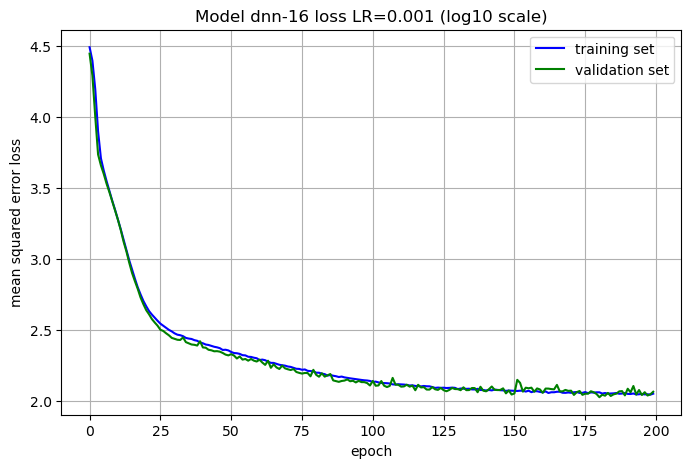

In [16]:
test_model(model_names[1]) # <-- change index (0 to 4) to change model